In [393]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import special
import emcee
from scipy.optimize import minimize
import time
import corner

In [48]:
def stylePlots():
    """A quick function to make subsequent plots look nice (requires seaborn).
    """
    sns.set_context("talk",font_scale=1.25)

    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15

    plt.rcParams['xtick.minor.size'] = 10
    plt.rcParams['ytick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2

    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.left'] = True
    plt.rcParams['ytick.right'] = True

    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams.update({
        #"text.usetex": True,turn off for now, not sure where my latex went
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
    
stylePlots()

In [49]:
#we start by taking 5,000 SNe:
df = pd.read_json("ELAsTiCC_SNe_5k.json")

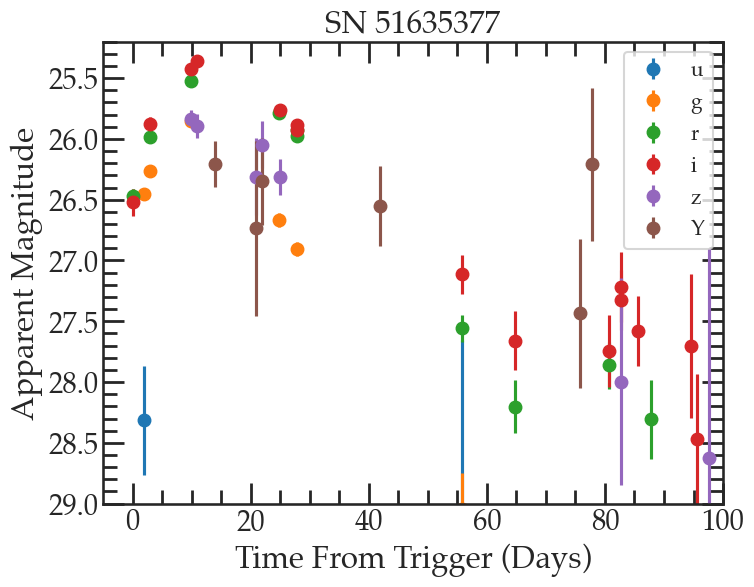

In [381]:
#Plot one supernova across all bands 
zp = 31.5

t0 = df['MJD_TRIGGER'].values[15]
t = np.array(df['MJD'].values[15]) - t0
mag = np.array(df['MAG'].values[15])
magerr = np.array(df['MAGERR'].values[15])

#floor the values that are missing
magerr[magerr == None] = 1.0
mag[mag == None] = zp

bands = np.array(df['Filter'].values[15])
photo_z = df['HOSTGAL_PHOTOZ'].values[15]
mwebv = df['MWEBV'].values[15]
name = df['SNID'].values[15]

band_list = 'ugrizY'

plt.figure(figsize=(8,6))
for band in band_list:
    idx = band == bands 
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band)

plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

In [382]:
#separately, I've created a gaussian-process model of the supernova across all bands. This is what the final fit looks like:
interpolated_DF = pd.read_csv("/Users/alexgagliano/Documents/Conferences/desc_feb23/superbol/SN51635377_ugrizY.txt", sep=' ')

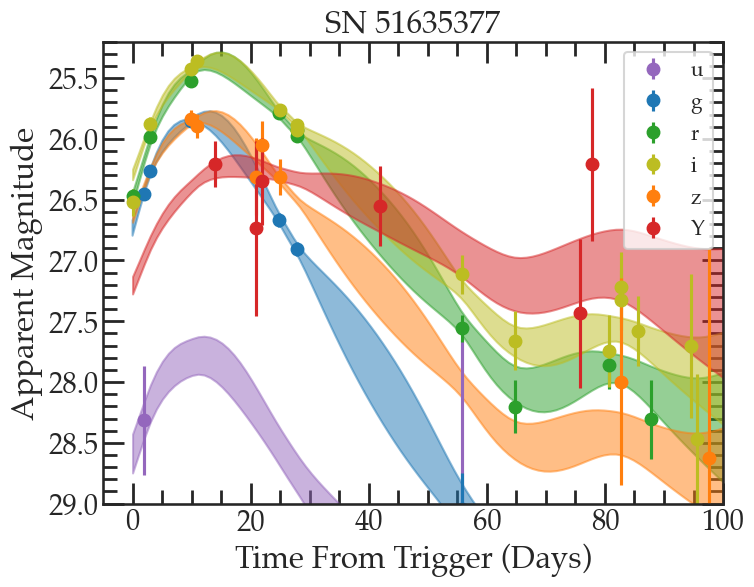

In [383]:
#interpolated light curves 
colset = sns.color_palette()
cols_bands = [colset[4], colset[0], colset[2], colset[8], colset[1], colset[3]]
    
plt.figure(figsize=(8,6))
for i in np.arange(len(band_list)):
    band = band_list[i]
    idx = band == bands 
    plt.fill_between(interpolated_DF['t'], interpolated_DF['%s'%band]-interpolated_DF['%s_err'%band], interpolated_DF['%s'%band]+interpolated_DF['%s_err'%band],  color=cols_bands[i], alpha=0.5)
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band, color=cols_bands[i])
    
plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

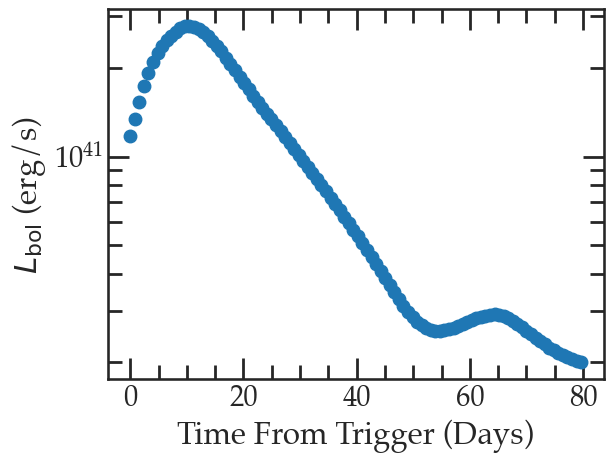

In [385]:
#and now, we've integrated a best fit black-body curve
#at each phase (after correcting for extinction and time dilation) 
#to get the bolometric luminosity as a function of time:
df_interp = pd.read_csv("/Users/alexgagliano/Documents/Conferences/desc_feb23/superbol/superbol_output_SN51635377/logL-bb_SN51635377_ugrizY.txt", sep='\t', header=None, names=['phase', 'logL', 'logLerr'])
plt.plot(df_interp['phase'], 10**df_interp['logL'], 'o')
plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"$L_{\rm bol}$ (erg/s)")
plt.yscale("log")

In [402]:
#some constants
tauNi = 8.77 #decay timescale of nickel, in days
tauCo = 111.3 #decay timescale of cobalt, in days

#energy production through Nickel and Cobalt decay
epsNi = 3.9E10
epsCo = 6.78E9

#Mass of the sun in grams
MSun = 2E33

#def variables/functions
#tau is the diffusion timescale and MNi is the total mass of nickel
def term1(tau):
    return tau/(2*tauNi)

def term2(tau):
    return tau * (tauCo - tauNi) / (2 * tauNi * tauCo)

def A(t, tau):
    return np.exp(-(term1(tau)**2)) * (np.sqrt(np.pi) * term1(tau) * special.erfi(t/tau - term1(tau)) + np.sqrt(np.pi) * term1(tau) * special.erfi(term1(tau)) + np.exp((t/tau - term1(tau))**2) - np.exp(term1(tau)**2))

def B(t, tau):
    return np.exp(-(term2(tau) - term1(tau))**2) * (np.sqrt(np.pi) * (term2(tau) - term1(tau)) * (special.erfi(term2(tau) - term1(tau)) - special.erfi(term2(tau) + t/tau - term1(tau))) + np.exp((term2(tau) + t/tau - term1(tau))**2) - np.exp((term2(tau) - term1(tau))**2))

def L(t, tau, MNi):
    return ((MNi*MSun) * np.exp(-(t/tau)**2) * ((epsNi - epsCo) * A(t, tau) +  B(t, tau)))

In [403]:
def log_likelihood(theta, tobs, yobs, yerr):
    log_like_sum = 0
    dt, tdiff, MNi = theta
    return -0.5 * np.sum((yobs - L(tobs+dt, tdiff, MNi)) ** 2 / yerr**2)

#assume flat priors on temp and Radius
def log_prior(theta):
    dt, tdiff, MNi = theta
    if 0 < dt < 10 and 7 < tdiff < 25 and 1.e-2 < MNi < 1.e-1:
        return 0.0
    return -np.inf

def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

dt = 0.0 #days
tdiff = 9. #days
MNi = 0.03 #Msol
theta = [dt, tdiff, MNi]

#take the first interpolated observation
t = df_interp['phase'].values
y = 10**df_interp['logL'].values
yerr = 2.303 * df_interp['logLerr'].values * y #error propagation!

#trim before opacity effects become important!
y = y[t < 30]
yerr = yerr[t < 30]
t = t[t < 30]

nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, theta, args=(t, y, yerr), bounds=[(0, 10), (7, 25), (1.e-2, 1.e-1)])

pos = soln.x + soln.x* 1.e-1*np.random.randn(64, 3)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, y, yerr)
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
time_spanned = end - start

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:56<00:00, 177.33it/s]


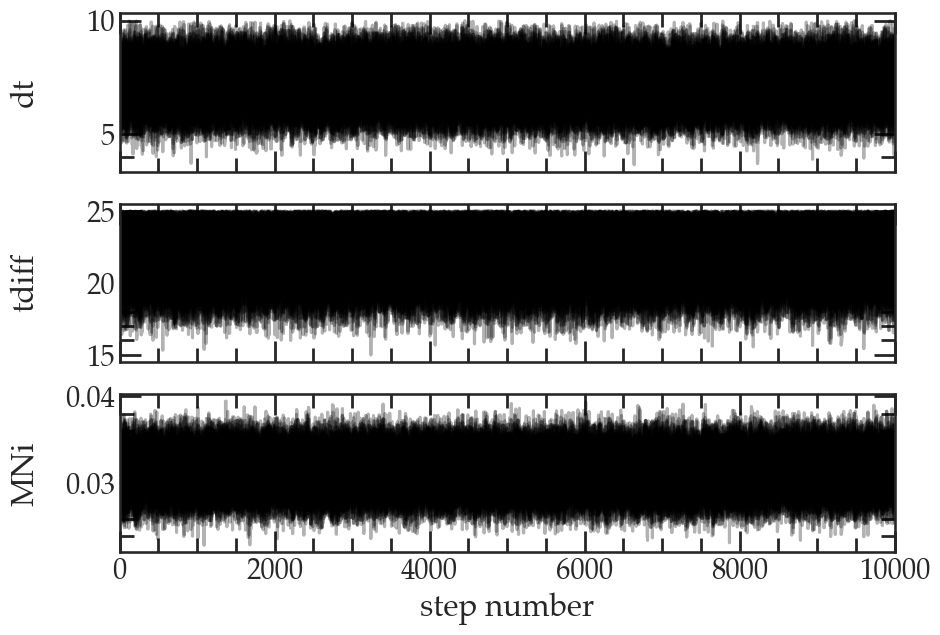

In [404]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["dt", "tdiff", "MNi"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

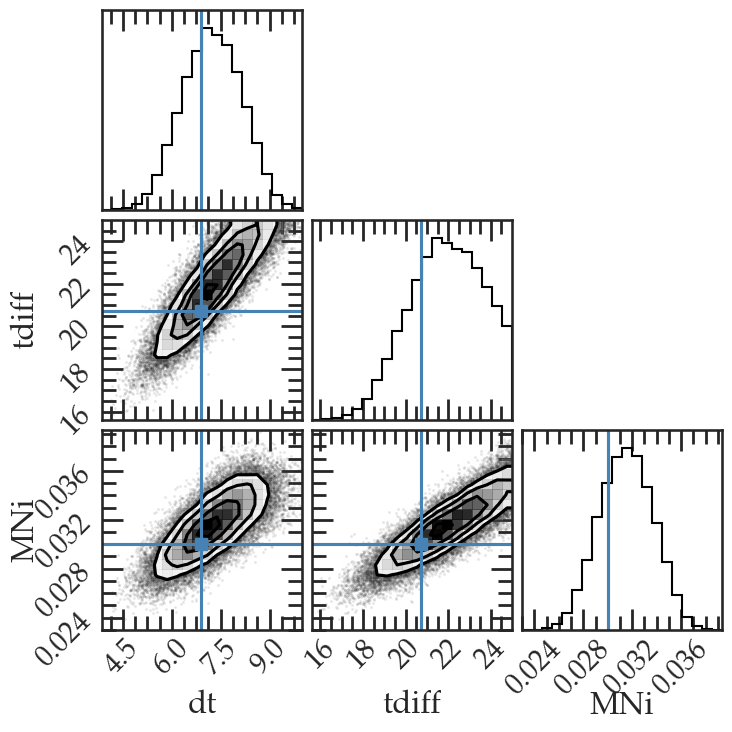

In [405]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[6.9, 20.7, 0.03]
);

In [409]:
dt = np.percentile(flat_samples[:, 0], [50])[0]
tdiff =  np.percentile(flat_samples[:, 1], [50])[0]
MNi =  np.percentile(flat_samples[:, 2], [50])[0]

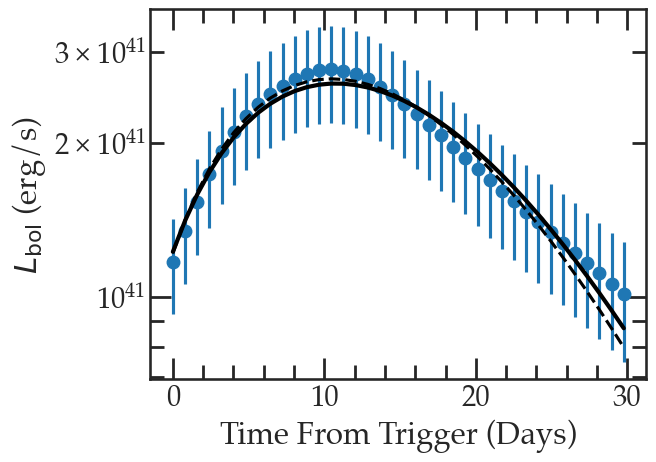

In [410]:
plt.plot(t, L(t+dt, tdiff, MNi), zorder=100, lw=3, c='k')
plt.plot(t, L(t+6.9, 20.7, 0.03), zorder=100, ls='--', c='k')
plt.errorbar(t, y, yerr, fmt='o')
plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"$L_{\rm bol}$ (erg/s)")
plt.yscale("log")

In [411]:
print("Time to run the MCMC: %.2f sec."% time_spanned)

Time to run the MCMC: 56.42 sec.


Both answers well within the uncertainties! Can we speed this up with jax and/or flowMC?